# HR data set

## Imports

In [2]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns",200)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

## Loading csv

In [3]:
emp_df = pd.read_csv("factory_employee_attrition.csv", encoding = "ISO-8859-1", low_memory=False)

## Exploratory Data Analysis

### Dataset examination

In [4]:
#Checking for missing values
emp_df.isna().sum()

sub_ID                          0
sub_fname                       0
sub_lname                       0
sub_age                         0
sub_sex                         0
sub_shift                       0
sub_team                        0
sub_role                        0
sub_coll_IDs                  812
sub_colls_same_sex_prtn       991
sub_health_h                    0
sub_commitment_h                0
sub_perceptiveness_h            0
sub_dexterity_h                 0
sub_sociality_h                 0
sub_goodness_h                  0
sub_strength_h                  0
sub_openmindedness_h            0
sub_workstyle_h                 0
sup_ID                        812
sup_fname                     812
sup_lname                     812
sup_age                       812
sup_sub_age_diff              812
sup_sex                       812
sup_role                      812
sup_commitment_h              812
sup_perceptiveness_h          812
sup_goodness_h                812
event_date    

Only the variable recorded_note_from_sup has missing values (358 to be precise) and this is not a numerical variable so no steps to mitigate it are required

In [5]:
emp_df.columns

Index(['sub_ID', 'sub_fname', 'sub_lname', 'sub_age', 'sub_sex', 'sub_shift',
       'sub_team', 'sub_role', 'sub_coll_IDs', 'sub_colls_same_sex_prtn',
       'sub_health_h', 'sub_commitment_h', 'sub_perceptiveness_h',
       'sub_dexterity_h', 'sub_sociality_h', 'sub_goodness_h',
       'sub_strength_h', 'sub_openmindedness_h', 'sub_workstyle_h', 'sup_ID',
       'sup_fname', 'sup_lname', 'sup_age', 'sup_sub_age_diff', 'sup_sex',
       'sup_role', 'sup_commitment_h', 'sup_perceptiveness_h',
       'sup_goodness_h', 'event_date', 'event_week_in_series',
       'event_day_in_series', 'event_weekday_num', 'event_weekday_name',
       'behav_comptype_h', 'behav_cause_h', 'actual_efficacy_h',
       'record_comptype', 'record_cause', 'recorded_efficacy',
       'recorded_note_from_sup', 'record_conf_matrix_h'],
      dtype='object')

In [6]:
emp_df.dtypes

sub_ID                       int64
sub_fname                   object
sub_lname                   object
sub_age                      int64
sub_sex                     object
sub_shift                   object
sub_team                    object
sub_role                    object
sub_coll_IDs                object
sub_colls_same_sex_prtn    float64
sub_health_h               float64
sub_commitment_h           float64
sub_perceptiveness_h       float64
sub_dexterity_h            float64
sub_sociality_h            float64
sub_goodness_h             float64
sub_strength_h             float64
sub_openmindedness_h       float64
sub_workstyle_h             object
sup_ID                     float64
sup_fname                   object
sup_lname                   object
sup_age                    float64
sup_sub_age_diff           float64
sup_sex                     object
sup_role                    object
sup_commitment_h           float64
sup_perceptiveness_h       float64
sup_goodness_h      

The columns [sub_colls_same_sex_prtn, sup_sub_age_diff, sup_commitment_h, sup_perceptiveness_h, sup_goodness_h, actual_efficacy_h, recorded_efficacy] are string even though their values are numbers. \
This is due to them having 'None' as some of the values.

In [7]:
# replacing 'None' entrie with np.nan values
emp_df.replace(to_replace = "None", value = np.nan, inplace = True)

In [8]:
# converting those columns to float columns
emp_df[["sub_colls_same_sex_prtn", "sup_sub_age_diff","sup_ID", "sup_commitment_h",\
        "sup_perceptiveness_h", "sup_goodness_h", "actual_efficacy_h", "recorded_efficacy"]] \
= emp_df[["sub_colls_same_sex_prtn", "sup_sub_age_diff", "sup_ID", "sup_commitment_h", \
          "sup_perceptiveness_h", "sup_goodness_h", "actual_efficacy_h", "recorded_efficacy"]].astype(float)

In [9]:
# The production director is not supervised by anyone and alsoi can't resign so hiw data is of no use
emp_df = emp_df[emp_df["sub_role"] != 'Production Director']

### Resignation exploration

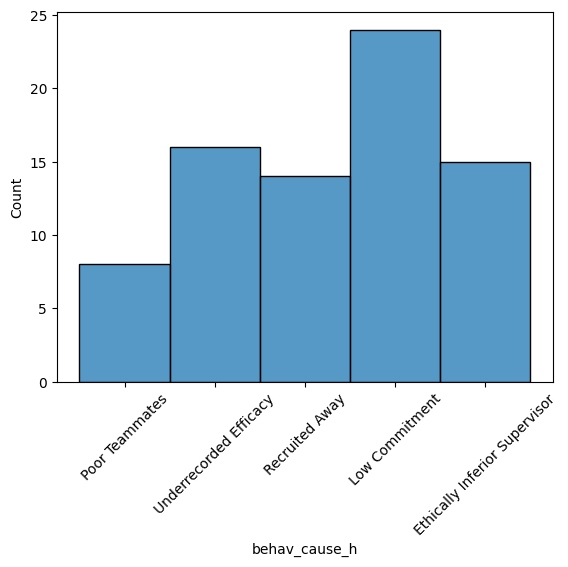

In [10]:
sns.histplot( x = emp_df.query("record_comptype == 'Resignation'")["behav_cause_h"])
plt.xticks(rotation = 45)
plt.show()

Upon investigation it was determined that "Ethically Inferior Supervisor" happens when the Goodness stat of the worker is higher than the goodnes stat of the supervisor and "Low Commitment" generally happens when the commitment of the worker is smaller that the commitment of the supervisor, though for this there are outliers.

**Problem 1: As can be seen from the barchart, employeees quit for very different reasons, making it increadibly hard to create an accurate prediction model**\
**Problem 2: because only 77 out of 683 workers quit and only 14 of them were recruited away, the always predict 0 baseline has a extremely high accuracy (for hired away 97.8%)**

### Efficacy prediction exploration

#### Not grouped by ID

In [11]:
test_not_grouped = emp_df[[
    "sub_ID",
    #"sub_fname",
    #"sub_lname",
    "sub_age",
    "sub_sex", 
    'sub_shift',
    'sub_team', 
    'sub_role',
    #"sub_coll_IDs",
    'sub_colls_same_sex_prtn',
    'sub_health_h', 
    'sub_commitment_h', 
    'sub_perceptiveness_h',
    'sub_dexterity_h', 
    'sub_sociality_h', 
    'sub_goodness_h',
    'sub_strength_h', 
    'sub_openmindedness_h', 
    'sub_workstyle_h',
    #"sup_ID",
    #"sup_fname",
    #"sup_lname",
    'sup_age', 
    'sup_sub_age_diff', 
    'sup_sex',
    'sup_role', 
    'sup_commitment_h', 
    'sup_perceptiveness_h',
    'sup_goodness_h',
    #"event_date",
    "event_week_in_series",
    "event_day_in_series",
    "event_weekday_num",
    #"event_weekday_name",
    #"behav_comptype_h",
    #"behav_cause_h",
    'actual_efficacy_h',
    "record_comptype",
    #"record_cause",
    'recorded_efficacy',
    #"recorded_note_from_sup",
    #"record_conf_matrix_h"
    ]].copy()
test_ng = test_not_grouped.query("record_comptype == 'Efficacy'")

In [12]:
test_ng

sub_ID  sub_age sub_sex sub_shift sub_team     sub_role   
1       98000001       40       F   Shift 1   Team 1  Team Leader  \
3       98000002       61       F   Shift 1   Team 2  Team Leader   
5       98000003       20       F   Shift 1   Team 3  Team Leader   
8       98000004       18       F   Shift 1   Team 4  Team Leader   
10      98000005       59       F   Shift 1   Team 5  Team Leader   
...          ...      ...     ...       ...      ...          ...   
411936  98000785       57       F   Shift 2  Team 12      Laborer   
411938  98000786       30       M   Shift 1   Team 8      Laborer   
411942  98000787       28       F   Shift 3  Team 21      Laborer   
411945  98000788       47       F   Shift 1   Team 6      Laborer   
411947  98000789       34       M   Shift 2  Team 12      Laborer   

        sub_colls_same_sex_prtn  sub_health_h  sub_commitment_h   
1                      0.714286         0.895             1.000  \
3                      0.714286         0.752             0.563   
5                      0.714286         0.573             0.907   
8                      0.714286         0.547             0.819   
10                     0.714286         0.777             0.629   
...                         ...           ...               ...   
411936                 0.631579         0.713             0.705   
411938                 0.631579         0.905             0.704   
411942                 0.526316         0.749             0.801   
411945                 0.526316         0.436             0.926   
411947                 0.315789         0.709             0.519   

        sub_perceptiveness_h  sub_dexterity_h  sub_sociality_h   
1                      0.659            0.592            0.799  \
3                      0.449            0.766            0.872   
5                      0.735            0.878            0.985   
8                      0.659            0.776            0.556   
10                     0.678            0.749            0.652   
...                      ...              ...              ...   
411936                 0.779            0.949            0.843   
411938                 0.878            0.786            0.925   
411942                 0.763            0.795            0.593   
411945                 0.813            0.781            0.706   
411947                 0.975            0.730            0.819   

        sub_goodness_h  sub_strength_h  sub_openmindedness_h sub_workstyle_h   
1                0.501           0.484                 0.676         Group A  \
3                0.655           0.786                 0.908         Group C   
5                0.840           0.900                 0.777         Group C   
8                0.755           0.872                 0.382         Group D   
10               0.686           0.566                 0.336         Group C   
...                ...             ...                   ...             ...   
411936           0.563           0.692                 0.780         Group C   
411938           0.548           0.755                 0.704         Group A   
411942           0.977           0.767                 0.613         Group C   
411945           0.438           0.812                 0.687         Group A   
411947           0.838           0.924                 0.631         Group B   

        sup_age  sup_sub_age_diff sup_sex       sup_role  sup_commitment_h   
1          24.0             -16.0       F  Shift Manager             0.842  \
3          24.0             -37.0       F  Shift Manager             0.842   
5          24.0               4.0       F  Shift Manager             0.842   
8          24.0               6.0       F  Shift Manager             0.842   
10         24.0             -35.0       F  Shift Manager             0.842   
...         ...               ...     ...            ...               ...   
411936     53.0              -4.0       F    Team Leader             0.945  

##### Looking for linearity between efficacy and numerical variables

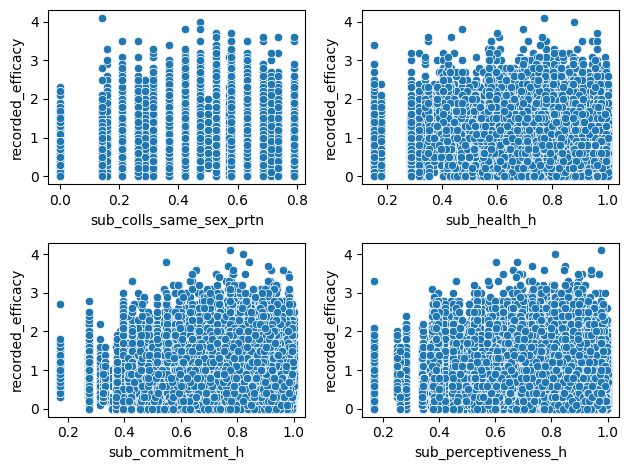

In [13]:
figure, axis = plt.subplots(2, 2)
sns.scatterplot( x = "sub_colls_same_sex_prtn", y = "recorded_efficacy", data = test_ng, ax = axis[0, 0])
sns.scatterplot( x = "sub_health_h", y = "recorded_efficacy", data = test_ng, ax = axis[0, 1])
sns.scatterplot( x = "sub_commitment_h", y = "recorded_efficacy", data = test_ng, ax = axis[1, 0])
sns.scatterplot( x = "sub_perceptiveness_h", y = "recorded_efficacy", data = test_ng, ax = axis[1, 1])
plt.tight_layout()
plt.show()

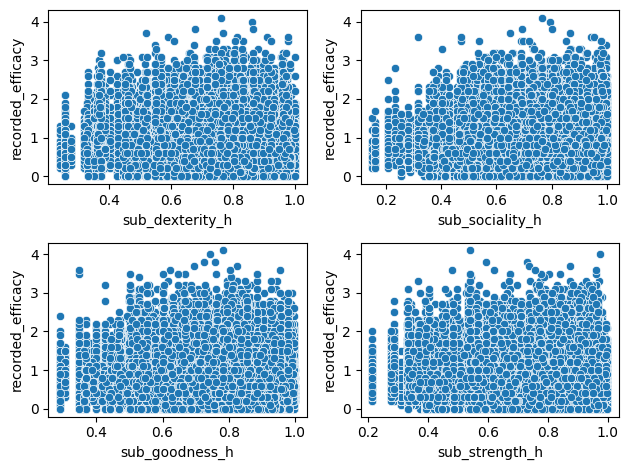

In [14]:
figure, axis = plt.subplots(2, 2)
sns.scatterplot( x = "sub_dexterity_h", y = "recorded_efficacy", data = test_ng, ax = axis[0, 0])
sns.scatterplot( x = "sub_sociality_h", y = "recorded_efficacy", data = test_ng, ax = axis[0, 1])
sns.scatterplot( x = "sub_goodness_h", y = "recorded_efficacy", data = test_ng, ax = axis[1, 0])
sns.scatterplot( x = "sub_strength_h", y = "recorded_efficacy", data = test_ng, ax = axis[1, 1])
plt.tight_layout()
plt.show()

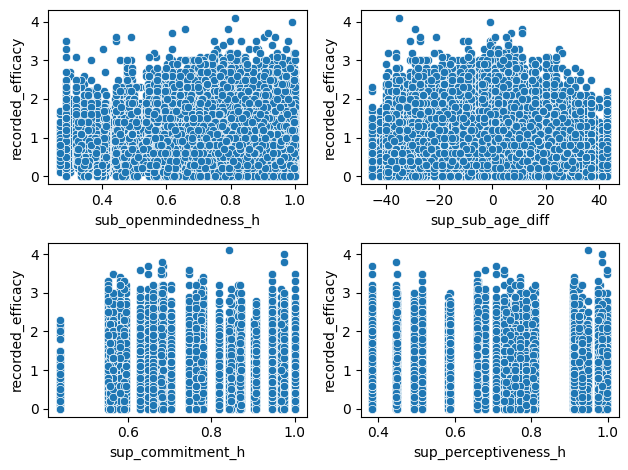

In [15]:
figure, axis = plt.subplots(2, 2)
sns.scatterplot( x = "sub_openmindedness_h", y = "recorded_efficacy", data = test_ng, ax = axis[0, 0])
sns.scatterplot( x = "sup_sub_age_diff", y = "recorded_efficacy", data = test_ng, ax = axis[0, 1])
sns.scatterplot( x = "sup_commitment_h", y = "recorded_efficacy", data = test_ng, ax = axis[1, 0])
sns.scatterplot( x = "sup_perceptiveness_h", y = "recorded_efficacy", data = test_ng, ax = axis[1, 1])
plt.tight_layout()
plt.show()

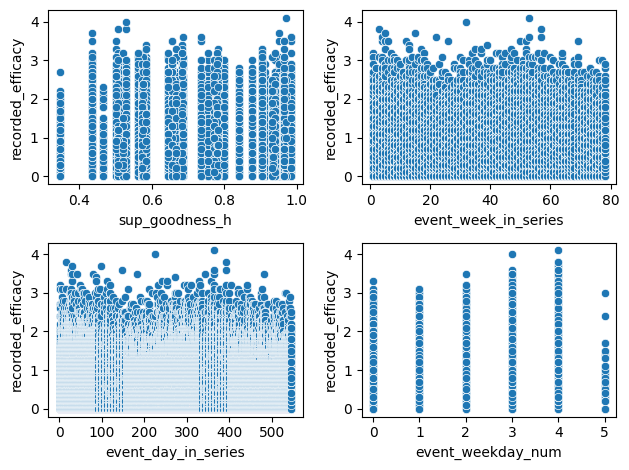

In [16]:
figure, axis = plt.subplots(2, 2)
sns.scatterplot( x = "sup_goodness_h", y = "recorded_efficacy", data = test_ng, ax = axis[0, 0])
sns.scatterplot( x = "event_week_in_series", y = "recorded_efficacy", data = test_ng, ax = axis[0, 1])
sns.scatterplot( x = "event_day_in_series", y = "recorded_efficacy", data = test_ng, ax = axis[1, 0])
sns.scatterplot( x = "event_weekday_num", y = "recorded_efficacy", data = test_ng, ax = axis[1, 1])
plt.tight_layout()
plt.show()

**No linear relationships are present, meaning a non-linear model is required**

##### Feasability of not-grouping by worker ID

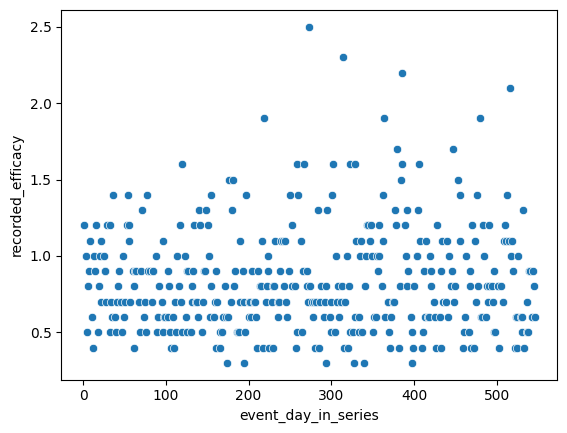

In [17]:
sns.scatterplot(x = "event_day_in_series", y = "recorded_efficacy", data = test_ng.query("sub_ID == 98000001"))
plt.show()

Since all the subject and supervisor features stay the same over the course of the entire time period, the only variables that \
change
are the day_number and week_day_num and it makes no sense to build a model only on those, and if all the variables are included \
the accuracy is really low.
Gradient Boost has an r^2 score of under 0.2

Agregating the efficacy by worker ( computing average worker efficacy over the time period) would make more sense

#### Agregating by workerID

In [18]:
test_df = emp_df[[
    "sub_ID",
    #"sub_fname",
    #"sub_lname",
    "sub_age",
    "sub_sex", 
    'sub_shift',
    'sub_team', 
    'sub_role',
    #"sub_coll_IDs",
    'sub_colls_same_sex_prtn',
    'sub_health_h', 
    'sub_commitment_h', 
    'sub_perceptiveness_h',
    'sub_dexterity_h', 
    'sub_sociality_h', 
    'sub_goodness_h',
    'sub_strength_h', 
    'sub_openmindedness_h', 
    'sub_workstyle_h',
    "sup_ID",
    #"sup_fname",
    #"sup_lname",
    'sup_age', 
    'sup_sub_age_diff', 
    'sup_sex',
    'sup_role', 
    'sup_commitment_h', 
    'sup_perceptiveness_h',
    'sup_goodness_h',
    #"event_date",
    #"event_week_in_series",
    #"event_day_in_series",
    "event_weekday_num",
    #"event_weekday_name",
    #"behav_comptype_h",
    #"behav_cause_h",
    'actual_efficacy_h',
    "record_comptype",
    #"record_cause",
    'recorded_efficacy',
    #"recorded_note_from_sup",
    #"record_conf_matrix_h"
    ]].copy()
test_df = test_df.query("record_comptype == 'Efficacy'")

In [19]:
lb = LabelEncoder()
test_df['sub_sex']= lb.fit_transform(test_df['sub_sex'])
test_df['sub_shift']= lb.fit_transform(test_df['sub_shift'])
test_df['sub_team']= lb.fit_transform(test_df['sub_team'])
test_df['sub_role']= lb.fit_transform(test_df['sub_role'])
test_df['sub_workstyle_h']= lb.fit_transform(test_df['sub_workstyle_h'])
test_df['sup_sex']= lb.fit_transform(test_df['sup_sex'])
test_df['sup_role']= lb.fit_transform(test_df['sup_role'])

In [20]:
test_df = test_df.groupby("sub_ID").agg("mean", numeric_only = True)

In [21]:
test_df

sub_age  sub_sex  sub_shift  sub_team  sub_role   
sub_ID                                                      
98000001     40.0      0.0        0.0       0.0       2.0  \
98000002     61.0      0.0        0.0      11.0       2.0   
98000003     20.0      0.0        0.0      17.0       2.0   
98000004     18.0      0.0        0.0      18.0       2.0   
98000005     59.0      0.0        0.0      19.0       2.0   
...           ...      ...        ...       ...       ...   
98000785     57.0      0.0        1.0       3.0       0.0   
98000786     30.0      1.0        0.0      22.0       0.0   
98000787     28.0      0.0        2.0      13.0       0.0   
98000788     47.0      0.0        0.0      20.0       0.0   
98000789     34.0      1.0        1.0       3.0       0.0   

          sub_colls_same_sex_prtn  sub_health_h  sub_commitment_h   
sub_ID                                                              
98000001                 0.714286         0.895             1.000  \
98000002                 0.714286         0.752             0.563   
98000003                 0.714286         0.573             0.907   
98000004                 0.714286         0.547             0.819   
98000005                 0.714286         0.777             0.629   
...                           ...           ...               ...   
98000785                 0.673684         0.713             0.705   
98000786                 0.631579         0.905             0.704   
98000787                 0.526316         0.749             0.801   
98000788                 0.526316         0.436             0.926   
98000789                 0.315789         0.709             0.519   

          sub_perceptiveness_h  sub_dexterity_h  sub_sociality_h   
sub_ID                                                             
98000001                 0.659            0.592            0.799  \
98000002                 0.449            0.766            0.872   
98000003                 0.735            0.878            0.985   
98000004                 0.659            0.776            0.556   
98000005                 0.678            0.749            0.652   
...                        ...              ...              ...   
98000785                 0.779            0.949            0.843   
98000786                 0.878            0.786            0.925   
98000787                 0.763            0.795            0.593   
98000788                 0.813            0.781            0.706   
98000789                 0.975            0.730            0.819   

          sub_goodness_h  sub_strength_h  sub_openmindedness_h   
sub_ID                                                           
98000001           0.501           0.484                 0.676  \
98000002           0.655           0.786                 0.908   
98000003           0.840           0.900                 0.777   
98000004           0.755           0.872                 0.382   
98000005           0.686           0.566                 0.336   
...                  ...             ...                   ...   
98000785           0.563           0.692                 0.780   
98000786           0.548           0.755                 0.704   
98000787           0.977           0.767                 0.613   
98000788           0.438           0.812                 0.687   
98000789           0.838           0.924                 0.631   

          sub_workstyle_h      sup_ID  sup_age  sup_sub_age_diff  sup_sex   
sub_ID                                                                      
98000001              0.0  98000216.0     24.0             -16.0      0.0  \
98000002              2.0  98000216.0     24.0             -37.0      0.0   
98000003              2.0  98000216.0     24.0               4.0      0.0   
98000004              3.0  98000216.0     24.0               6.0      0.0   
98000005              2.0  98000216.0     24.0             -35.0      0.0   
...                   ...         .

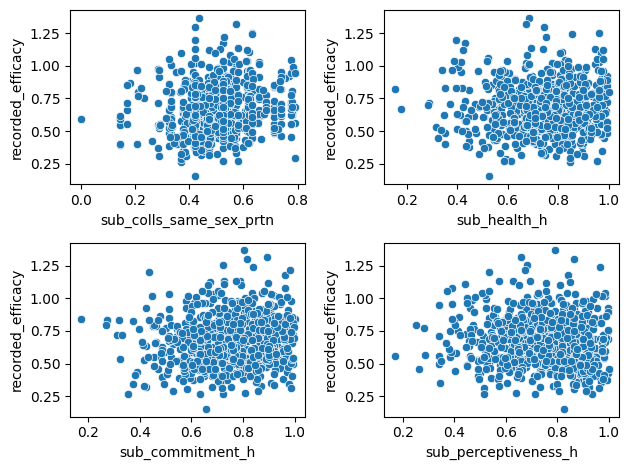

In [22]:
figure, axis = plt.subplots(2, 2)
sns.scatterplot( x = "sub_colls_same_sex_prtn", y = "recorded_efficacy", data = test_df, ax = axis[0, 0])
sns.scatterplot( x = "sub_health_h", y = "recorded_efficacy", data = test_df, ax = axis[0, 1])
sns.scatterplot( x = "sub_commitment_h", y = "recorded_efficacy", data = test_df, ax = axis[1, 0])
sns.scatterplot( x = "sub_perceptiveness_h", y = "recorded_efficacy", data = test_df, ax = axis[1, 1])
plt.tight_layout()
plt.show()

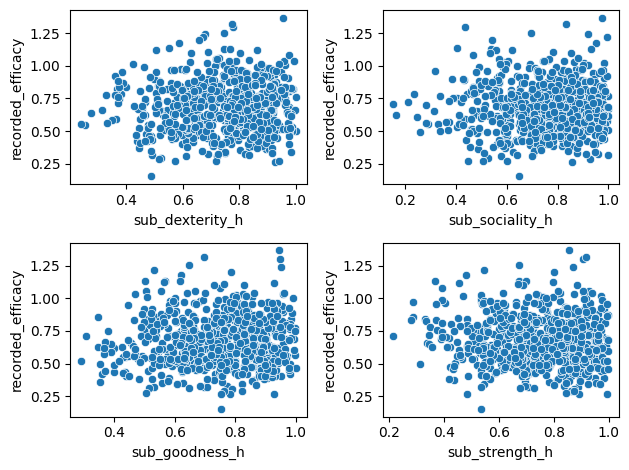

In [23]:
figure, axis = plt.subplots(2, 2)
sns.scatterplot( x = "sub_dexterity_h", y = "recorded_efficacy", data = test_df, ax = axis[0, 0])
sns.scatterplot( x = "sub_sociality_h", y = "recorded_efficacy", data = test_df, ax = axis[0, 1])
sns.scatterplot( x = "sub_goodness_h", y = "recorded_efficacy", data = test_df, ax = axis[1, 0])
sns.scatterplot( x = "sub_strength_h", y = "recorded_efficacy", data = test_df, ax = axis[1, 1])
plt.tight_layout()
plt.show()

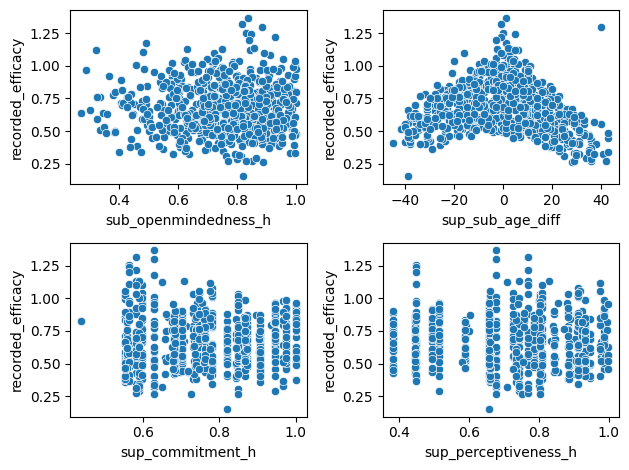

In [24]:
figure, axis = plt.subplots(2, 2)
sns.scatterplot( x = "sub_openmindedness_h", y = "recorded_efficacy", data = test_df, ax = axis[0, 0])
sns.scatterplot( x = "sup_sub_age_diff", y = "recorded_efficacy", data = test_df, ax = axis[0, 1])
sns.scatterplot( x = "sup_commitment_h", y = "recorded_efficacy", data = test_df, ax = axis[1, 0])
sns.scatterplot( x = "sup_perceptiveness_h", y = "recorded_efficacy", data = test_df, ax = axis[1, 1])
plt.tight_layout()
plt.show()

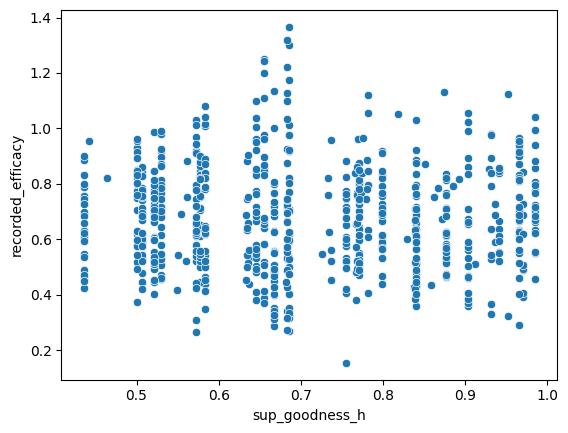

In [25]:
sns.scatterplot( x = "sup_goodness_h", y = "recorded_efficacy", data = test_df)
plt.show()

**After agregating the data exibits more recognizable patterns, but still exibits no large linearity**

Question: Which variables are not hidden and could be used for a rational real world model? \
**sub_age** \
**sub_sex** \
**sub_shift** \
**sub_team**  \
**sub_role** \
**sub_colls_same_sex_prtn** \
**sup_ID** \
**sup_age** \
**sup_sub_age_diff** \
**sup_sex** \
**sup_role** \
**record_comptype** \
**recorded_efficacy** \
Using only these features leads to a very low score, however if the assume that the **sub_workstyle_h** is known \
(which is a somewhat feasable assuption), the score can be greatly improved

#### Gradient Boosting Regression

##### Recorded efficacy

In [26]:
x = test_df[[
    "sub_age",
    "sub_sex", 
    'sub_shift',
    'sub_team', 
    #'sub_role', 
    'sub_colls_same_sex_prtn',
    #'sub_health_h', 
    #'sub_commitment_h', 
    #'sub_perceptiveness_h',
    #'sub_dexterity_h', 
    #'sub_sociality_h', 
    #'sub_goodness_h',
    #'sub_strength_h', 
    #'sub_openmindedness_h', 
    'sub_workstyle_h', 
    'sup_sub_age_diff', 
    #"sup_ID",
    #'sup_sex',
    #'sup_role', 
    #'sup_commitment_h', 
    #'sup_perceptiveness_h',
    #'sup_goodness_h'
    ]].copy()
y = test_df["recorded_efficacy"]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.9381194493827046

##### Actual Efficiacy

In [27]:
x = test_df[[
    "sub_age",
    "sub_sex", 
    'sub_shift',
    'sub_team', 
    #'sub_role', 
    'sub_colls_same_sex_prtn',
    #'sub_health_h', 
    #'sub_commitment_h', 
    #'sub_perceptiveness_h',
    #'sub_dexterity_h', 
    #'sub_sociality_h', 
    #'sub_goodness_h',
    #'sub_strength_h', #hidden but increases r^2
    #'sub_openmindedness_h', 
    'sub_workstyle_h', 
    'sup_sub_age_diff', 
    #'sup_sex',
    #'sup_role', 
    #'sup_commitment_h', #hidden but increases r^2
    #'sup_perceptiveness_h',
    #'sup_goodness_h', #hidden but increases r^2
    ]].copy()
y = test_df["actual_efficacy_h"]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
reg.score(X_test, y_test)

0.9353530842960476

#### Adding aditional variables based on record_comptype

In [28]:
#making a binary column for workers that had an Idea event
emp_df["Idea"] = 0
index_list = emp_df.query("record_comptype == 'Idea'").index
emp_df.loc[index_list, "Idea"] = 1
idea_df = emp_df[["sub_ID","Idea"]].groupby("sub_ID").sum()

#making a binary column for workers that had a Feat event
emp_df["Feat"] = 0
index_list = emp_df.query("record_comptype == 'Feat'").index
emp_df.loc[index_list, "Feat"] = 1
feat_df = emp_df[["sub_ID","Feat"]].groupby("sub_ID").sum()

#making a binary column for workers that had a Slip event
emp_df["Slip"] = 0
index_list = emp_df.query("record_comptype == 'Slip'").index
emp_df.loc[index_list, "Slip"] = 1
slip_df = emp_df[["sub_ID","Slip"]].groupby("sub_ID").sum()

#making a binary column for workers that had a Teamwork event
emp_df["Teamwork"] = 0
index_list = emp_df.query("record_comptype == 'Teamwork'").index
emp_df.loc[index_list, "Teamwork"] = 1
team_work_df = emp_df[["sub_ID","Teamwork"]].groupby("sub_ID").sum()

#making a binary column for workers that had a Disruption event
emp_df["Disruption"] = 0
index_list = emp_df.query("record_comptype == 'Disruption'").index
emp_df.loc[index_list, "Disruption"] = 1
distruption_df = emp_df[["sub_ID","Disruption"]].groupby("sub_ID").sum()

#making a binary column for workers that had a Sacrifice event
emp_df["Sacrifice"] = 0
index_list = emp_df.query("record_comptype == 'Sacrifice'").index
emp_df.loc[index_list, "Sacrifice"] = 1
sacrifice_df = emp_df[["sub_ID","Sacrifice"]].groupby("sub_ID").sum()

#making a binary column for workers that had a Sabotage event
emp_df["Sabotage"] = 0
index_list = emp_df.query("record_comptype == 'Sabotage'").index
emp_df.loc[index_list, "Sabotage"] = 1
sabotage_df = emp_df[["sub_ID","Sabotage"]].groupby("sub_ID").sum()

#### Mergeing data frames

In [29]:
new_df = pd.merge(test_df, idea_df, on = "sub_ID", how = "inner")
new_df = new_df.merge(feat_df, on = "sub_ID", how = "inner")
new_df = new_df.merge(slip_df, on = "sub_ID", how = "inner")
new_df = new_df.merge(team_work_df, on = "sub_ID", how = "inner")
new_df = new_df.merge(distruption_df, on = "sub_ID", how = "inner")
new_df = new_df.merge(sacrifice_df, on = "sub_ID", how = "inner")
new_df = new_df.merge(sabotage_df, on = "sub_ID", how = "inner")

In [30]:
new_df

sub_age  sub_sex  sub_shift  sub_team  sub_role   
sub_ID                                                      
98000001     40.0      0.0        0.0       0.0       2.0  \
98000002     61.0      0.0        0.0      11.0       2.0   
98000003     20.0      0.0        0.0      17.0       2.0   
98000004     18.0      0.0        0.0      18.0       2.0   
98000005     59.0      0.0        0.0      19.0       2.0   
...           ...      ...        ...       ...       ...   
98000785     57.0      0.0        1.0       3.0       0.0   
98000786     30.0      1.0        0.0      22.0       0.0   
98000787     28.0      0.0        2.0      13.0       0.0   
98000788     47.0      0.0        0.0      20.0       0.0   
98000789     34.0      1.0        1.0       3.0       0.0   

          sub_colls_same_sex_prtn  sub_health_h  sub_commitment_h   
sub_ID                                                              
98000001                 0.714286         0.895             1.000  \
98000002                 0.714286         0.752             0.563   
98000003                 0.714286         0.573             0.907   
98000004                 0.714286         0.547             0.819   
98000005                 0.714286         0.777             0.629   
...                           ...           ...               ...   
98000785                 0.673684         0.713             0.705   
98000786                 0.631579         0.905             0.704   
98000787                 0.526316         0.749             0.801   
98000788                 0.526316         0.436             0.926   
98000789                 0.315789         0.709             0.519   

          sub_perceptiveness_h  sub_dexterity_h  sub_sociality_h   
sub_ID                                                             
98000001                 0.659            0.592            0.799  \
98000002                 0.449            0.766            0.872   
98000003                 0.735            0.878            0.985   
98000004                 0.659            0.776            0.556   
98000005                 0.678            0.749            0.652   
...                        ...              ...              ...   
98000785                 0.779            0.949            0.843   
98000786                 0.878            0.786            0.925   
98000787                 0.763            0.795            0.593   
98000788                 0.813            0.781            0.706   
98000789                 0.975            0.730            0.819   

          sub_goodness_h  sub_strength_h  sub_openmindedness_h   
sub_ID                                                           
98000001           0.501           0.484                 0.676  \
98000002           0.655           0.786                 0.908   
98000003           0.840           0.900                 0.777   
98000004           0.755           0.872                 0.382   
98000005           0.686           0.566                 0.336   
...                  ...             ...                   ...   
98000785           0.563           0.692                 0.780   
98000786           0.548           0.755                 0.704   
98000787           0.977           0.767                 0.613   
98000788           0.438           0.812                 0.687   
98000789           0.838           0.924                 0.631   

          sub_workstyle_h      sup_ID  sup_age  sup_sub_age_diff  sup_sex   
sub_ID                                                                      
98000001              0.0  98000216.0     24.0             -16.0      0.0  \
98000002              2.0  98000216.0     24.0             -37.0      0.0   
98000003              2.0  98000216.0     24.0               4.0      0.0   
98000004              3.0  98000216.0     24.0               6.0      0.0   
98000005              2.0  98000216.0     24.0             -35.0      0.0   
...                   ...         .

#### Regression with new features

In [31]:
x = new_df[[
    "sub_age",
    #"sub_sex", 
    #'sub_shift',
    #'sub_team', 
    #'sub_role', 
    'sub_colls_same_sex_prtn',
    #'sub_health_h', 
    #'sub_commitment_h', 
    #'sub_perceptiveness_h',
    #'sub_dexterity_h', 
    #'sub_sociality_h', 
    #'sub_goodness_h',
    #'sub_strength_h', 
    #'sub_openmindedness_h', 
    'sub_workstyle_h',
    #"sup_ID",
    'sup_sub_age_diff', 
    #'sup_sex',
    #'sup_role', 
    #'sup_commitment_h', 
    #'sup_perceptiveness_h',
    #'sup_goodness_h',
    #"Idea",
    #"Feat",
    #"Slip",
    #"Teamwork", 
    #"Disruption",
    #"Sacrifice",
    #"Sabotage"
    ]].copy()
y = new_df["recorded_efficacy"]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)
reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train, y_train)
vis = pd.DataFrame(columns = ["features","importance"])
vis["features"] = reg.feature_names_in_
vis["importance"] = reg.feature_importances_
reg.score(X_test, y_test)

0.9352010310532038

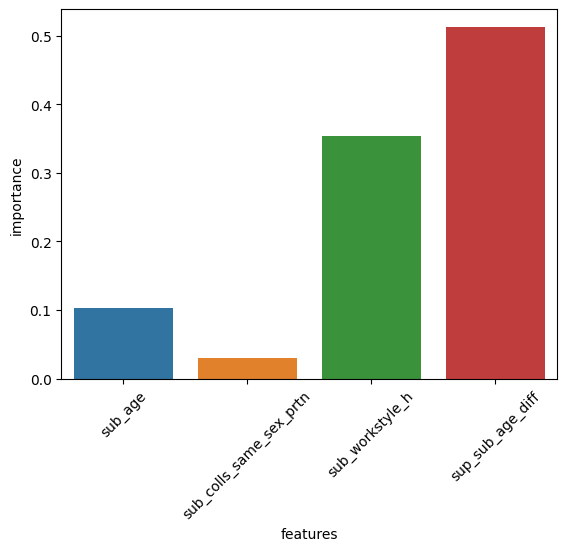

In [32]:
sns.barplot( x = "features", y = "importance", data = vis)
plt.xticks(rotation = 45)
plt.show()

In [33]:
vis

features  importance
0                  sub_age    0.103650
1  sub_colls_same_sex_prtn    0.030073
2          sub_workstyle_h    0.353226
3         sup_sub_age_diff    0.513051

In [34]:
from sklearn.model_selection import cross_val_score
x = new_df[[
    "sub_age",
    #"sub_sex", 
    #'sub_shift',
    #'sub_team', 
    #'sub_role', 
    'sub_colls_same_sex_prtn',
    #'sub_health_h', 
    #'sub_commitment_h', 
    #'sub_perceptiveness_h',
    #'sub_dexterity_h', 
    #'sub_sociality_h', 
    #'sub_goodness_h',
    #'sub_strength_h', 
    #'sub_openmindedness_h', 
    'sub_workstyle_h',
    #"sup_ID",
    'sup_sub_age_diff', 
    #'sup_sex',
    #'sup_role', 
    #'sup_commitment_h', 
    #'sup_perceptiveness_h',
    #'sup_goodness_h',
    #"Idea",
    #"Feat",
    #"Slip",
    #"Teamwork", 
    #"Disruption",
    #"Sacrifice",
    #"Sabotage"
    ]].copy()
y = new_df["recorded_efficacy"]
reg = GradientBoostingRegressor(random_state=0)
scores = cross_val_score(reg, x, y, cv=3)
print("%0.4f accuracy with a standard deviation of %0.3f" % (scores.mean(), scores.std()))

0.8702 accuracy with a standard deviation of 0.040


**Adding Feat and Sabotage to the features slighty increases the accuracy, but it increases the std more than it increases the accuracy so its probably best to keep them out**

**Problems:** \
**P1**: Only 683 workers. Quite small for Data Science, but only 0.04% of all companies in austria have more than 250 workers. 683 may be good enough?\
**P2**: Data set is syntethic and potentially does not resemble real workd relationships.

##### Efficacy based on day/month agregation

###### Weekday agregation

In [35]:
test_2_df = emp_df[[
    #"sub_ID",
    #"sub_fname",
    #"sub_lname",
    #"sub_age",
    #"sub_sex", 
    #'sub_shift',
    #'sub_team', 
    #'sub_role',
    #"sub_coll_IDs",
    #'sub_colls_same_sex_prtn',
    #'sub_health_h', 
    #'sub_commitment_h', 
    #'sub_perceptiveness_h',
    #'sub_dexterity_h', 
    #'sub_sociality_h', 
    #'sub_goodness_h',
    #'sub_strength_h', 
    #'sub_openmindedness_h', 
    #'sub_workstyle_h',
    #"sup_ID",
    #"sup_fname",
    #"sup_lname",
    #'sup_age', 
    #'sup_sub_age_diff', 
    #'sup_sex',
    #'sup_role', 
    #'sup_commitment_h', 
    #'sup_perceptiveness_h',
    #'sup_goodness_h',
    #"event_date",
    #"event_week_in_series",
    #"event_day_in_series",
    "event_weekday_num",
    "event_weekday_name",
    #"behav_comptype_h",
    #"behav_cause_h",
    #'actual_efficacy_h',
    "record_comptype",
    #"record_cause",
    'recorded_efficacy',
    #"recorded_note_from_sup",
    #"record_conf_matrix_h"
    ]].copy()
test_2_df = test_2_df.query("record_comptype == 'Efficacy'")

In [36]:
test_2_df = test_2_df.groupby("event_weekday_num", as_index = False).agg("mean", numeric_only = True)

In [37]:
test_2_df

event_weekday_num  recorded_efficacy
0                  0           0.576178
1                  1           0.622729
2                  2           0.667403
3                  3           0.716516
4                  4           0.761521
5                  5           0.798305

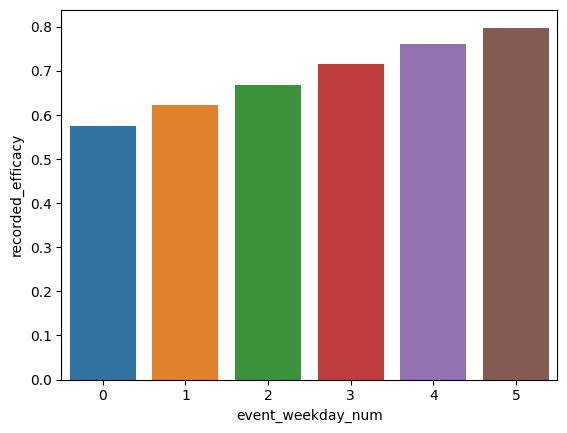

In [38]:
sns.barplot( x = "event_weekday_num", y = "recorded_efficacy", data = test_2_df)
plt.show()

###### Week in series

In [39]:
test_3_df = emp_df[[
    #"sub_ID",
    #"sub_fname",
    #"sub_lname",
    #"sub_age",
    #"sub_sex", 
    #'sub_shift',
    #'sub_team', 
    #'sub_role',
    #"sub_coll_IDs",
    #'sub_colls_same_sex_prtn',
    #'sub_health_h', 
    #'sub_commitment_h', 
    #'sub_perceptiveness_h',
    #'sub_dexterity_h', 
    #'sub_sociality_h', 
    #'sub_goodness_h',
    #'sub_strength_h', 
    #'sub_openmindedness_h', 
    #'sub_workstyle_h',
    #"sup_ID",
    #"sup_fname",
    #"sup_lname",
    #'sup_age', 
    #'sup_sub_age_diff', 
    #'sup_sex',
    #'sup_role', 
    #'sup_commitment_h', 
    #'sup_perceptiveness_h',
    #'sup_goodness_h',
    #"event_date",
    "event_week_in_series",
    #"event_day_in_series",
    #"event_weekday_num",
    #"event_weekday_name",
    #"behav_comptype_h",
    #"behav_cause_h",
    #'actual_efficacy_h',
    "record_comptype",
    #"record_cause",
    'recorded_efficacy',
    #"recorded_note_from_sup",
    #"record_conf_matrix_h"
    ]].copy()
test_3_df = test_3_df.query("record_comptype == 'Efficacy'")

In [40]:
test_3_df = test_3_df.groupby("event_week_in_series", as_index = False).agg("mean", numeric_only = True)

In [41]:
test_3_df

event_week_in_series  recorded_efficacy
0                      1           0.708571
1                      2           0.696988
2                      3           0.713864
3                      4           0.801629
4                      5           0.723438
..                   ...                ...
73                    74           0.667127
74                    75           0.576826
75                    76           0.578321
76                    77           0.594497
77                    78           0.663915

[78 rows x 2 columns]

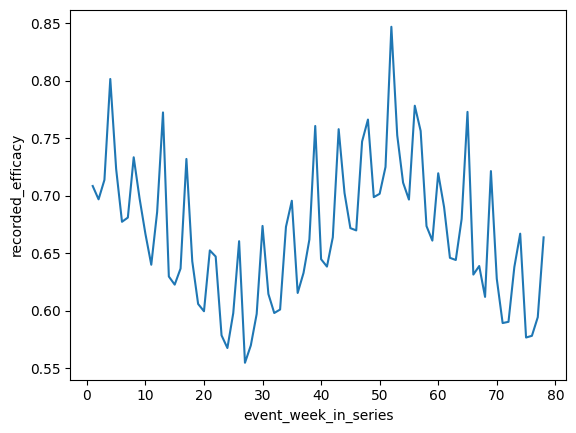

In [42]:
sns.lineplot( x = "event_week_in_series", y = "recorded_efficacy", data = test_3_df)
plt.show()

###### Month in series

In [43]:
test_3_df = emp_df[[
    #"sub_ID",
    #"sub_fname",
    #"sub_lname",
    #"sub_age",
    #"sub_sex", 
    #'sub_shift',
    #'sub_team', 
    #'sub_role',
    #"sub_coll_IDs",
    #'sub_colls_same_sex_prtn',
    #'sub_health_h', 
    #'sub_commitment_h', 
    #'sub_perceptiveness_h',
    #'sub_dexterity_h', 
    #'sub_sociality_h', 
    #'sub_goodness_h',
    #'sub_strength_h', 
    #'sub_openmindedness_h', 
    #'sub_workstyle_h',
    #"sup_ID",
    #"sup_fname",
    #"sup_lname",
    #'sup_age', 
    #'sup_sub_age_diff', 
    #'sup_sex',
    #'sup_role', 
    #'sup_commitment_h', 
    #'sup_perceptiveness_h',
    #'sup_goodness_h',
    "event_date",
    #"event_week_in_series",
    #"event_day_in_series",
    #"event_weekday_num",
    #"event_weekday_name",
    #"behav_comptype_h",
    #"behav_cause_h",
    #'actual_efficacy_h',
    "record_comptype",
    #"record_cause",
    'recorded_efficacy',
    #"recorded_note_from_sup",
    #"record_conf_matrix_h"
    ]].copy()
test_3_df = test_3_df.query("record_comptype == 'Efficacy'")

In [44]:
#test_3_df["event_date"] = test_3_df["event_date"].astype('datetime64[M]')
test_3_df["event_date"] = pd.to_datetime(test_3_df["event_date"])
test_3_df["event_date"] = test_3_df["event_date"].dt.to_period('M')
test_3_df = test_3_df.groupby("event_date", as_index = False).agg("mean", numeric_only = True)
lb = LabelEncoder()
test_3_df['month']= lb.fit_transform(test_3_df['event_date'])

In [45]:
test_3_df

event_date  recorded_efficacy  month
0     2021-01           0.743536      0
1     2021-02           0.698866      1
2     2021-03           0.682297      2
3     2021-04           0.670003      3
4     2021-05           0.621770      4
5     2021-06           0.599648      5
6     2021-07           0.608776      6
7     2021-08           0.629151      7
8     2021-09           0.664306      8
9     2021-10           0.689751      9
10    2021-11           0.698619     10
11    2021-12           0.756190     11
12    2022-01           0.730269     12
13    2022-02           0.693948     13
14    2022-03           0.679899     14
15    2022-04           0.660357     15
16    2022-05           0.613427     16
17    2022-06           0.604179     17

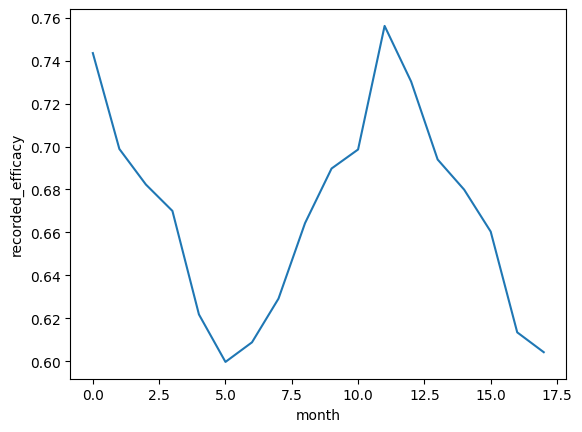

In [46]:
sns.lineplot( x = "month", y = "recorded_efficacy", data = test_3_df)
plt.show()

###### Day in month

In [47]:
test_3_df = emp_df[[
    #"sub_ID",
    #"sub_fname",
    #"sub_lname",
    #"sub_age",
    #"sub_sex", 
    #'sub_shift',
    #'sub_team', 
    #'sub_role',
    #"sub_coll_IDs",
    #'sub_colls_same_sex_prtn',
    #'sub_health_h', 
    #'sub_commitment_h', 
    #'sub_perceptiveness_h',
    #'sub_dexterity_h', 
    #'sub_sociality_h', 
    #'sub_goodness_h',
    #'sub_strength_h', 
    #'sub_openmindedness_h', 
    #'sub_workstyle_h',
    #"sup_ID",
    #"sup_fname",
    #"sup_lname",
    #'sup_age', 
    #'sup_sub_age_diff', 
    #'sup_sex',
    #'sup_role', 
    #'sup_commitment_h', 
    #'sup_perceptiveness_h',
    #'sup_goodness_h',
    "event_date",
    #"event_week_in_series",
    #"event_day_in_series",
    #"event_weekday_num",
    #"event_weekday_name",
    #"behav_comptype_h",
    #"behav_cause_h",
    #'actual_efficacy_h',
    "record_comptype",
    #"record_cause",
    'recorded_efficacy',
    #"recorded_note_from_sup",
    #"record_conf_matrix_h"
    ]].copy()
test_3_df = test_3_df.query("record_comptype == 'Efficacy'")

In [48]:
#test_3_df["event_date"] = test_3_df["event_date"].astype('datetime64[M]')
test_3_df["event_date"] = pd.to_datetime(test_3_df["event_date"])
test_3_df["event_date"] = test_3_df["event_date"].dt.day
test_3_df = test_3_df.groupby("event_date", as_index = False).agg("mean", numeric_only = True)

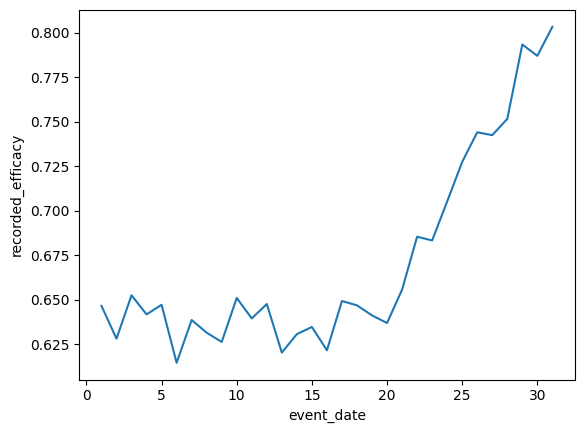

In [49]:
sns.lineplot( x = "event_date", y = "recorded_efficacy", data = test_3_df)
plt.show()

###### Event day in series

In [50]:
test_3_df = emp_df[[
    #"sub_ID",
    #"sub_fname",
    #"sub_lname",
    #"sub_age",
    #"sub_sex", 
    #'sub_shift',
    #'sub_team', 
    #'sub_role',
    #"sub_coll_IDs",
    #'sub_colls_same_sex_prtn',
    #'sub_health_h', 
    #'sub_commitment_h', 
    #'sub_perceptiveness_h',
    #'sub_dexterity_h', 
    #'sub_sociality_h', 
    #'sub_goodness_h',
    #'sub_strength_h', 
    #'sub_openmindedness_h', 
    #'sub_workstyle_h',
    #"sup_ID",
    #"sup_fname",
    #"sup_lname",
    #'sup_age', 
    #'sup_sub_age_diff', 
    #'sup_sex',
    #'sup_role', 
    #'sup_commitment_h', 
    #'sup_perceptiveness_h',
    #'sup_goodness_h',
    #"event_date",
    #"event_week_in_series",
    "event_day_in_series",
    #"event_weekday_num",
    #"event_weekday_name",
    #"behav_comptype_h",
    #"behav_cause_h",
    #'actual_efficacy_h',
    "record_comptype",
    #"record_cause",
    'recorded_efficacy',
    #"recorded_note_from_sup",
    #"record_conf_matrix_h"
    ]].copy()
test_3_df = test_3_df.query("record_comptype == 'Efficacy'")

In [51]:
test_3_df

event_day_in_series record_comptype  recorded_efficacy
1                         1        Efficacy                1.2
3                         1        Efficacy                0.8
5                         1        Efficacy                0.9
8                         1        Efficacy                0.9
10                        1        Efficacy                0.1
...                     ...             ...                ...
411936                  546        Efficacy                0.7
411938                  546        Efficacy                0.8
411942                  546        Efficacy                1.5
411945                  546        Efficacy                0.3
411947                  546        Efficacy                0.4

[191272 rows x 3 columns]

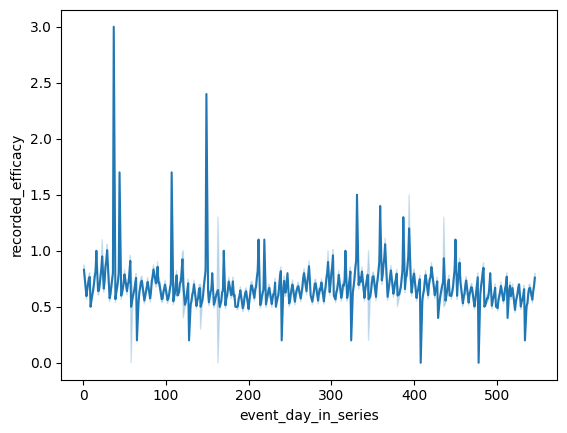

In [52]:
sns.lineplot( x = "event_day_in_series", y = "recorded_efficacy", data = test_3_df)
plt.show()

#### Classification into worker groups

In [53]:
class_df = new_df
class_df["positive_events"] = class_df["Idea"] + class_df["Feat"] + class_df["Teamwork"] + class_df["Sacrifice"]
class_df["negative_events"] = class_df["Slip"] + class_df["Disruption"]+class_df["Sabotage"]

In [54]:
 x = class_df[["recorded_efficacy","positive_events","negative_events"]].copy()

In [55]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init = 10)
kmeans.fit(x)
class_df["label"] = kmeans.labels_

In [56]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init = 10)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)

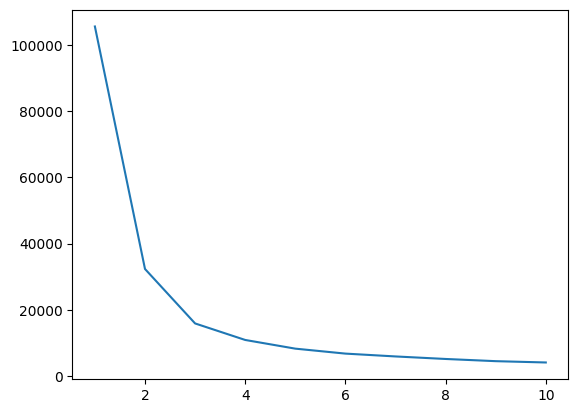

In [57]:
plt.plot(range(1, 11), wcss)

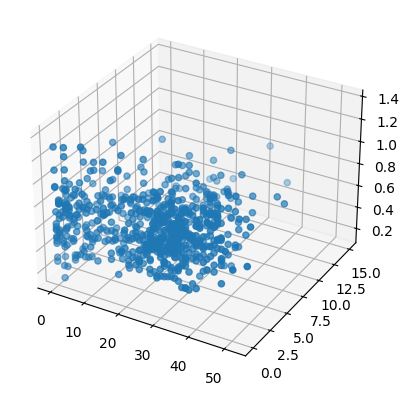

In [58]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(class_df["positive_events"], class_df["negative_events"],class_df["recorded_efficacy"]);

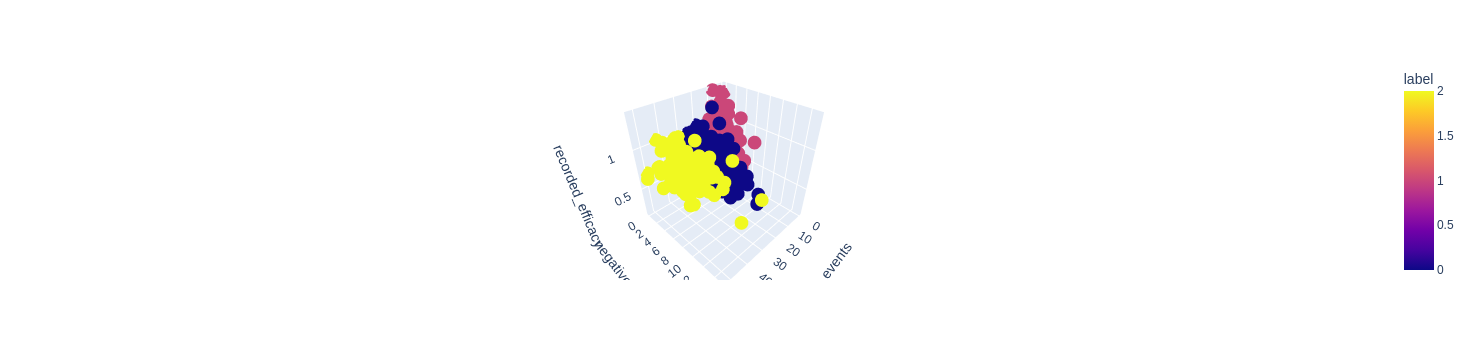

In [59]:
import plotly.express as px
fig = px.scatter_3d(class_df, x="positive_events", y="negative_events", z="recorded_efficacy",
              color='label')
fig.show()